<header>
    <p style="text-align:center; font-size: 30px; color: green"><b>DATA CLEANING</b></p>
</header>

<div style="border: 2px solid  gray;">
    The objective of this notebook is to propose an analytical view of Brazillian e-commerce relationship datasets. For this we will first go trough an exploratory data analysis using graphical tools to create self explanatory plots for better understanding what is behind braziian online purchasing. Finally we will look at customers reviews and implement.
    
We will go trough a extensive journey for understanding the data and plotting some useful charts to clarify the concepts and get insights from data and, at the end, we will go trough a step-by-step code on text preparating and sentiment classification using the reviews left from customer on online platforms. I hope you enjoy this notebook!
</div>

  <a id="top"></a>
    <div class="list-group" id="list-tab" role="tablist">
    <h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Content</h3>
        
* [1. Background Introduction](#1)
    - [a. Scenario](#1a)
    - [b. Data and PackageImport](#1b)
* [2. Data Cleaning](#2)
    - [a. Data Overview](#2a)
    - [b. Handling Null Values](#2b)
        - [i. Replacing empty text](#2bi)
        - [ii. Replacing empty datetime data](#2bii)
        - [iii. Replacing empty quantity data](#2biii)
        - [iv. Replacing empty categorical data](#2biv)

 <a id="1"></a>
<font color="lightblack" size=+2.5><b>1. Introduction</b></font>

 <a id="1a"></a>
<font color="lightblue" size=+2><b>a. Scenario</b></font>

In [61]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Ecommerce

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Ecommerce


This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

 <a id="1b"></a>
<font color="lightblue" size=+2.5><b>b. Data and Package import</b></font>

In [64]:
!pip install pyspark

In [62]:
#data cleaning
import numpy as np
import pandas as pd
import datetime
import math

#Imputation
from sklearn.impute import KNNImputer

#datapreprocessing + clustering
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.stats import skew, norm, probplot, boxcox
from sklearn.metrics import mean_squared_error

#SVC
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score


#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [65]:
#import data
customer_df = pd.read_csv('Data/OriginalDatasets/olist_customers_dataset.csv')
geolocation_df = pd.read_csv('Data/OriginalDatasets/olist_geolocation_dataset.csv')
orders_df = pd.read_csv('Data/OriginalDatasets/olist_orders_dataset.csv')
items_df = pd.read_csv('Data/OriginalDatasets/olist_order_items_dataset.csv')
payments_df = pd.read_csv('Data/OriginalDatasets/olist_order_payments_dataset.csv')
reviews_df = pd.read_csv('Data/OriginalDatasets/olist_order_reviews_dataset.csv')
products_df = pd.read_csv('Data/OriginalDatasets/olist_products_dataset.csv')
sellers_df = pd.read_csv('Data/OriginalDatasets/olist_sellers_dataset.csv')

# Collections for each dataset
datasets = [customer_df, geolocation_df, orders_df, items_df, payments_df,
            reviews_df, products_df, sellers_df]
names = ['customer_df', 'geolocation_df', 'orders_df', 'items_df', 'payments_df',
         'reviews_df', 'products_df', 'sellers_df']

In [ ]:
#save clean datasets into clean data folders
customer_df.to_csv('../Data/CleanData/clean_customer_df.csv')
geolocation_df.to_csv('../Data/CleanData/clean_geolocation_df.csv')
items_df.to_csv('../Data/CleanData/clean_order_items_df.csv')
payments_df.to_csv('../Data/CleanData/clean_order_payments_df.csv')
sellers_df.to_csv('../Data/CleanData/clean_sellers_df.csv')

 <a id="2"></a>
<font color="lightblack" size=+2.5><b>2. Data Cleaning</b></font>

 <a id="2a"></a>
<font color="lightblue" size=+2><b>a. Data Overview</b></font>

In [ ]:
#constructing info table for datasets
info_tab = pd.DataFrame({})

info_tab['Dataset'] = names
info_tab['Shape'] = [df.shape for df in datasets]
info_tab['null-amount'] = [df.isnull().sum().sum() for df in datasets]
info_tab['num_of_null_col'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
info_tab['null_col'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

info_tab

,Dataset,Shape,null-amount,num_of_null_col,null_col
0,customer_df,"(99441, 5)",0,0,
1,geolocation_df,"(1000163, 5)",0,0,
2,orders_df,"(99441, 8)",4908,3,"order_approved_at, order_delivered_carrier_dat..."
3,items_df,"(112650, 7)",0,0,
4,payments_df,"(103886, 5)",0,0,
5,reviews_df,"(99224, 7)",145903,2,"review_comment_title, review_comment_message"
6,products_df,"(32951, 9)",2448,8,"product_category_name, product_name_lenght, pr..."
7,sellers_df,"(3095, 4)",0,0,


As we could observe, table <em>orders_df</em>, <em>reviews_df</em>, <em>products_df</em> contains null values.

 <a id="2b"></a>
<font color="lightblue" size=+2><b>b. Handling null values</b></font>

 <a id="2bi"></a>
<font color="green" size=+2><b>i. String null values (reviews_df)</b></font>

In [ ]:
reviews_df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

As we could see that, null values in reviews_df are empty string. Let's replace it with empty string.

In [ ]:
#replacing null values with empty string
reviews_df['review_comment_title'].fillna(" ", inplace=True)
reviews_df['review_comment_message'].fillna(" ", inplace=True)

reviews_df.isnull().sum()

review_id                  0
order_id                   0
review_score               0
review_comment_title       0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64

In [ ]:
#store clean_data
reviews_df.to_csv('../Data/CleanData/clean_reviews_df.csv')

 <a id="2bii"></a>
<font color="green" size=+2><b>ii. Datetime Null Values (orders_df)</b></font>

In [66]:
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [67]:
#convert to datetime value
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_delivered_carrier_date'] = pd.to_datetime(orders_df['order_delivered_carrier_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])

orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](4), object(4)
memory usage: 6.1+ MB


In [68]:
products_df.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [69]:
#loop through col that contains null
for i in [4,5,6]:
    #find the time difference (to find the mean time difference)
    time_diff = orders_df.iloc[:,i-1] - orders_df.iloc[:,i]
    #use formula: col that has missing value = col that does not have + mean(time difference between 2 columns)
    orders_df.iloc[:,i].fillna(value=orders_df[orders_df.iloc[:,i].isnull()].iloc[:,i-1] + time_diff.mean(), inplace=True)

orders_df.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [71]:
#store clean_data
orders_df.to_csv('Data/CleanData/clean_orders_df.csv')

 <a id="2biii"></a>
<font color="green" size=+2><b>iii. Quantity Null Values (products_df)</b></font>

In [ ]:
products_df[products_df['product_length_cm'].isnull()==True]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
products_df.drop(index=18851, inplace=True)

In [ ]:
products_df.isnull().sum()

product_id                      0
product_category_name         609
product_name_lenght           609
product_description_lenght    609
product_photos_qty            609
product_weight_g                1
product_length_cm               1
product_height_cm               1
product_width_cm                1
dtype: int64

Since we have non-null values in order_purchase_timestamp, we could use this column to replace when assuming that for all the rows that contains the null values, the delta time between each column is the same.

In [ ]:
products_df[products_df['product_weight_g'].isnull()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN


Looks like the null values in the last 3 cols belongs to 1 single product. We will try to see whether there is anyproducts is alike.

In [ ]:
products_df[(products_df['product_category_name']=='bebes')&(products_df['product_name_lenght']==60.0)&(products_df['product_description_lenght']==865.0)]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
1294,6fd08d44046ab994b96ff38ad6fcfba1,bebes,60.0,865.0,1.0,500.0,23.0,23.0,23.0
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN


We found one. We will try to replace it with the same value.

In [ ]:
for col in [5,6,7,8]:
    products_df.iloc[8578,col] = products_df.iloc[1294, col]

products_df.iloc[8578,:]

product_id                    09ff539a621711667c43eba6a3bd8466
product_category_name                                    bebes
product_name_lenght                                       60.0
product_description_lenght                               865.0
product_photos_qty                                         3.0
product_weight_g                                         500.0
product_length_cm                                         23.0
product_height_cm                                         23.0
product_width_cm                                          23.0
Name: 8578, dtype: object

The method above is similar to KNN where we check those most similiar products to the one that has the null values and replace those nulls with already-existed one. We will optimize a model in Sklearn: KNNImpute to perform null values replacement in the 3 remaining columns that containing null.

We will use the entire relational database to apply the KNNImpute to find the most precise number to replace those null values.

## Create a dataframe that has all necessary values

In [ ]:
#avg prices for each product
product_price = items_df.groupby('product_id').agg({'price':'mean','freight_value':'mean'})

#mege into product_df
merged_products = pd.merge(products_df, product_price, on='product_id', how='left')

#drop product_id
merged_products.drop(columns=['product_id'], inplace=True)

# Identify and drop non-numeric or non-continuous columns
non_numeric_columns = merged_products.select_dtypes(exclude=['float64', 'int64']).columns
merged_products_quant = merged_products.drop(columns=non_numeric_columns)

#display
merged_products_quant

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
0,40.0,287.0,1.0,225.0,16.0,10.0,14.0,10.910000,7.390000
1,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,248.000000,17.990000
2,46.0,250.0,1.0,154.0,18.0,9.0,15.0,79.800000,7.820000
3,27.0,261.0,1.0,371.0,26.0,4.0,26.0,112.300000,9.540000
4,37.0,402.0,4.0,625.0,20.0,17.0,13.0,37.900000,8.290000
...,...,...,...,...,...,...,...,...,...
32945,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,69.900000,31.103939
32946,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,200.000000,17.495000
32947,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,127.300000,17.608000
32948,60.0,156.0,2.0,700.0,31.0,13.0,20.0,32.702857,19.182857


In [ ]:
model_product_df = merged_products_quant.dropna()
model_product_df.isnull().sum()

product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
price                         0
freight_value                 0
dtype: int64

## Create the model

In [ ]:
#col with missing val
col_with_null = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty']

# Create training set
train_df = model_product_df.copy()

# Set random values in specified columns to NaN
for col_ind in [2, 3, 4]:
    for num in range(round(len(model_product_df) * 0.018)):
        rand_place = np.random.randint(1, len(model_product_df))
        train_df.iloc[rand_place, col_ind] = np.nan

# Check for null values in the modified DataFrame
print(train_df.isnull().sum())

product_name_lenght             0
product_description_lenght      0
product_photos_qty            576
product_weight_g              575
product_length_cm             576
product_height_cm               0
product_width_cm                0
price                           0
freight_value                   0
dtype: int64


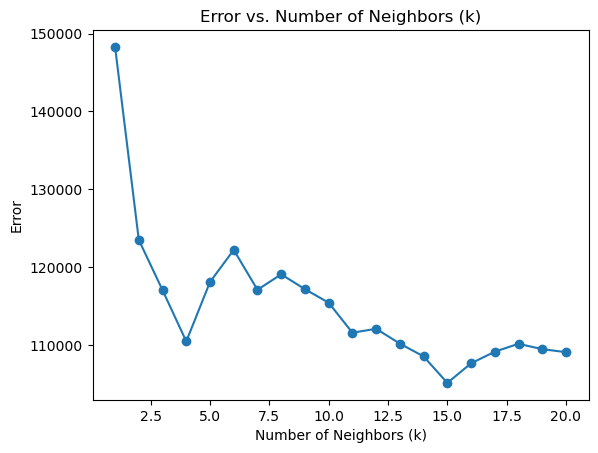

In [ ]:
# Store error values for each k
errors = []

#loop through k-values to test the perfect k
for k in range(1,21):
    imputer = KNNImputer(n_neighbors=k)

    df_imputed = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)

    # Evaluate the performance using mean squared error
    error = 0

    for col_ind in [2, 3, 4]:
        error += mean_squared_error(model_product_df.iloc[:, col_ind], df_imputed.iloc[:, col_ind])

    #append error
    errors.append(error)

# Visualizization
plt.plot(range(1,21), errors, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.title('Error vs. Number of Neighbors (k)')

#display
plt.show()

==> Choose K=4

In [ ]:
# Instantiate the KNNImputer
imputer = KNNImputer(n_neighbors=4)

# Impute missing values
df_imputed = pd.DataFrame(imputer.fit_transform(merged_products_quant), columns=merged_products_quant.columns)

df_imputed.isnull().sum()

product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
price                         0
freight_value                 0
dtype: int64

In [ ]:
for col in col_with_null:
    products_df[col] = df_imputed[col]

products_df.isnull().sum()

product_id                      0
product_category_name         609
product_name_lenght             0
product_description_lenght      0
product_photos_qty              0
product_weight_g                0
product_length_cm               0
product_height_cm               0
product_width_cm                0
dtype: int64

In [ ]:
#store clean_data
products_df.to_csv('../Data/CleanData/clean_products_df.csv')

 <a id="2biv"></a>
<font color="green" size=+2><b>iv. Categorical Null Values (products_df)</b></font>

In [ ]:
products_df = pd.read_csv('Data/CleanData/clean_products_df.csv')

In [ ]:
#import packages
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
products_df.isnull().sum()

Unnamed: 0                      0
product_id                      0
product_category_name         609
product_name_lenght             0
product_description_lenght      0
product_photos_qty              0
product_weight_g                0
product_length_cm               0
product_height_cm               0
product_width_cm                0
dtype: int64

## Model Building

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("RFC").getOrCreate()

# Load df into spark
spark_products_df = spark.createDataFrame(products_df)

#display
spark_products_df.show(5)

+----------+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|Unnamed: 0|          product_id|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|
+----------+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|         0|1e9e8ef04dbcff454...|           perfumaria|               40.0|                     287.0|               1.0|           225.0|             16.0|             10.0|            14.0|
|         1|3aa071139cb16b67c...|                artes|               44.0|                     276.0|               1.0|          1000.0|             30.0|             18.0|            20.0|
|         2|96bd76ec8810374ed...|       

In [ ]:
#features & target
features = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_photos_qty', 'product_length_cm', 'product_length_cm', 'product_width_cm']
target = 'product_category_name'

# Split data into training and testing sets
train_data = products_df.dropna(subset=[target])
spark_train_data = spark.createDataFrame(train_data)

test_data = products_df[products_df[target].isnull()]
spark_test_data = spark.createDataFrame(test_data)

#display
spark_train_data.show(5)

+----------+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|Unnamed: 0|          product_id|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|
+----------+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|         0|1e9e8ef04dbcff454...|           perfumaria|               40.0|                     287.0|               1.0|           225.0|             16.0|             10.0|            14.0|
|         1|3aa071139cb16b67c...|                artes|               44.0|                     276.0|               1.0|          1000.0|             30.0|             18.0|            20.0|
|         2|96bd76ec8810374ed...|       

In [ ]:
#vectorize
assembler = VectorAssembler(inputCols=features, outputCol="features")
indexer = StringIndexer(inputCol=target, outputCol="label")
spark_train_data = assembler.transform(spark_train_data).select("features", target)
spark_train_data = indexer.fit(spark_train_data).transform(spark_train_data)

# Split data into training and testing sets
train_df, test_df = spark_train_data.randomSplit([0.8, 0.2], seed=123)

train_df.show(5)

+--------------------+---------------------+-----+
|            features|product_category_name|label|
+--------------------+---------------------+-----+
|[5.0,267.0,1.0,1....|     moveis_decoracao|  2.0|
|[7.0,289.0,1.0,1....|                bebes| 10.0|
|[9.0,90.0,1.0,1.0...| fashion_bolsas_e_...| 12.0|
|[9.0,254.0,1.0,1....|        esporte_lazer|  1.0|
|[9.0,254.0,1.0,1....|        esporte_lazer|  1.0|
+--------------------+---------------------+-----+
only showing top 5 rows



In [ ]:
#train model
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
model = rf.fit(train_df)

In [ ]:
#prediction
predictions = model.transform(test_df)

#Evaluate Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions)

#display
print("Accuracy:", accuracy)

Accuracy: 0.21165407738554032


In [ ]:
#store clean_data
products_df.to_csv('../Data/CleanData/clean_products_df.csv')

## Data Characteristics

In [ ]:
#constructing describe table for datasets
des_tab = pd.DataFrame()
type_list = []

for df in datasets:
    des_tab = pd.concat([des_tab,df.describe().transpose()], axis=0)

#object type
obj_df = pd.DataFrame({})

for df in datasets:
    for col in df:
        obj_df = pd.concat([obj_df, pd.DataFrame({'col':col, 'type':df[col].dtypes}, index=[0])],axis=0)

#merge back to des_tab
des_tab = des_tab.merge(obj_df, left_on=des_tab.index, right_on='col')

#drop unecessary columns
des_tab.drop(['25%','75%','top','freq'],axis=1,inplace=True)
des_tab.set_index('col', inplace=True)

#display
des_tab

NameError: name 'datasets' is not defined